# Week 3. Day 3. Exercises from Chapter 9 of FSStDS. 
## Fundamentals of Social Data Science. MT 2022

Within your study pod discuss the following questions. Please submit an individual assignment by 12:30pm Monday, October 31st🎃 |  2022 on Canvas. 

# Telling a story using multiple distributions and multiple media 

In this exercise |  you are asked to show several skills that signal an accumulation of knowledge about research design in social data science. 

We are not expecting a complex statistical analysis. In fact |  the goal should be to determine a simple approach wherever possible. 

Tell a story about a current event that enables you to make use of:
- Two different platforms. The default would be Twitter and Reddit |  but you can flex your API skills should you choose. 
- At least one means comparison test (e.g. |  t-test or ANOVA)
- At least one correlation (determining whether it makes sense in a parametric or nonparametric form) |  
- At least one scatterplot | 
- At least one faceted distributional graph, such as a boxplot or violin plot.

**Step 1**. Link the story you tell to an intuition from either past literature, other current events, or personal experience. Please write it in a formal manner regardless of how you derive your intuitions. 

> For example, as a really simple case, "While crypto continues its descent in value, some communities appear adamant that it will continue to accrue in value. I explore the popularity of two cryptocurrencies: Ethereum and Monero by looking at the most recent posts discussing these currencies on Twitter and Reddit. By comparing the frequency over time of the last mentions of either, we can get a sense of how popular these currencies are, as well as whether they appear to benefit from organic content or suffer from scams and bots." 

**Step 2**. Describe the data you are collecting to make the comparison or explore the issue. Indicate what data makes sense and for what purpose

> For example, for Twitter, I am using the recent search and collecting the 5000 most recent mentions of "ethereum" and "monero". For each of these, I will examine whether there is a link in the tweet and the amount of public engagement from the tweet. For Reddit, I will be complementing this with a similar search using `praw`. Note: More details might be useful in your work

**Step 3**. Report the observations and their distributions as well as any issues you have encountered with sample size.  This should include visual presentations of the distributions.

**Step 4**. Report any bivariate or multivariate comparisons. If you have a hypothesis, restate it here and consider it in relation to the tests. This can include visual elements such as a heatmap or trendline.

**Step 5**. Reflect on findings in relation to the intuition or research motivation. 

This set of steps is loosely based on the structure of a research paper. The reason that I assert it is loosely based is because here we have slightly lower (or perhaps different) expectations. 
- In a research paper, we would expect the motivations for the analysis to be primarily based on academic conversations and past research.
- We wouldn't necessarily prescribe specific analyses _a priori_ in a paper. 
- Instead of merely reflecting on the quality of the tests we would want to link specific details back to the literature review or motivating concerns more directly. 
- We would probably pay much more attention to sample size and coverage. Here I have have made no specific demands of coverage except 'large enough to detect a reasonable difference'.  

Notes: 
1. Be careful with the means comparison tests. They are more likely to be reasonable within platform (one query to another or one subreddit to another) than between platform. 
2. The emphasis here is on setting up the argument with data and examining the shape of that data. We should exercise caution on generalisibility. However, it is worth considering that at least superficially by collecting more than 100 tweets or posts. 
3. You can use another platform, but please use a hot API and not a prepared data dump. 
4. It is not assumed that someone reading this paper will be able to collect the same data as you, so segment your code in such a way that you download and collect a suitable sample and then in another part perform any relevant subsequent analyses. 

You can submit the data alongside the code then so that someone can reproduce the findings. Please note that actual tweet data can only be shared within class and any public archive of this work should exclude the tweet to be rehydrated as per Twitter's Developer Terms.   

There is no rubric for this exercise. It will be graded by the course instructor and given both small amounts of qualitative feedback and a grade out of 100 on the Oxford scale (that is where 50 is a pass, 65 is a strong pass, 70 is a distinction). It will be returned in one week from submission.

## Helper Functions

In [301]:
import pandas as pd
pd.set_option('max_colwidth', 50)
import numpy as np
import random as rnd
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
import warnings
warnings.filterwarnings("ignore")
import datetime as dt
import dateutil
import re
import requests as req
from scipy.stats import chi2_contingency, ttest_ind

In [302]:
def smooth_timeseries(col, n):

    smoothed = col.copy()

    for i in range(n):

        new_smoothed = smoothed.copy()

        for j in range(len(smoothed)):

            if not j in [0, len(smoothed) - 1]:
                new_smoothed[j] = smoothed[j] / 2 + (
                    smoothed[j - 1] + smoothed[j + 1]) / 4
            elif j == 0:
                new_smoothed[j] = (
                    smoothed[j] + smoothed[j + 1]) / 2
            else:
                new_smoothed[j] = (
                    smoothed[j] + smoothed[j - 1]) / 2

        smoothed = new_smoothed.copy()

    return smoothed

def clean_tokenizer(text):
    tokens =  re.sub('[^a-zA-Z\d\s]', '', text).lower().split(' ') if isinstance(text, str) else []
    tokens = [re.sub('\n', '', token) for token in tokens]
    return tokens

def moral_scoring(df, col, ref_dict):

    scores = []

    for doc in df[col].map(clean_tokenizer):

        care = []
        fairness = []
        loyalty = []
        authority = []
        sanctity = []

        for token in doc:
            if token in ref_dict.keys():
                care.append(ref_dict[token]['care'])
                fairness.append(ref_dict[token]['fairness'])
                loyalty.append(ref_dict[token]['loyalty'])
                authority.append(ref_dict[token]['authority'])
                sanctity.append(ref_dict[token]['sanctity'])

        scores.append({
            'care': np.mean(care),
            'fairness': np.mean(fairness),
            'loyalty': np.mean(loyalty),
            'authority': np.mean(authority),
            'sanctity': np.mean(sanctity),
        })

    return pd.DataFrame(scores)


def scatter_layer(df, foundation, color, axes):

    days_of_year = [date.timetuple().tm_yday for date in df.index]
    axes.scatter(df.index, df[(foundation, 'mean')], color=color, label=foundation, alpha=.5)
    z = np.polyfit(days_of_year, df[(foundation, 'mean')], 1)
    p = np.poly1d(z)
    axes.plot(df.index, p(days_of_year), color=color, path_effects=[pe.Stroke(linewidth=3, foreground='black'), pe.Normal()])

def scattered_morals(df, axes):

    scatter_layer(df, 'care', 'blue', axes)
    scatter_layer(df, 'fairness', 'yellow', axes)
    scatter_layer(df, 'loyalty', 'green', axes)
    scatter_layer(df, 'authority', 'red', axes)
    scatter_layer(df, 'sanctity', 'pink', axes)
    
    axes.legend()

def normalize_morality(row, foundation):
    foundations = ['care', 'fairness', 'loyalty', 'authority', 'sanctity']
    return row[(foundation, 'mean')] / (
        row[('care', 'mean')] + row[('fairness', 'mean')] + row[('loyalty', 'mean')] + row[('authority', 'mean')] + row[('sanctity', 'mean')] 
    )

def chi_squared_score(row):

    data = [
        [row['tweet_care'], row['tweet_fairness'], row['tweet_loyalty'], row['tweet_authority'], row['tweet_sanctity']],
        [row['news_care'], row['news_fairness'], row['news_loyalty'], row['news_authority'], row['news_sanctity']]
    ]

    stat, p, dof, expected = chi2_contingency(data)

    return stat


def similarity_subplot(df, lag_title, axes, lagged=False):

    x = df.index if not lagged else df['created_day']
    days_of_year = [date.timetuple().tm_yday for date in x]
    z = np.polyfit(days_of_year, df['chi2'], 3)
    p = np.poly1d(z)

    axes.plot(x, smooth_timeseries(df['chi2'], 10))
    axes.set_title(f'Chi-Squared Statistic ({lag_title})')
    axes.set_ylim(0, .0015)
    axes.set_xticks(['2021-01-01', '2021-05-01', '2021-09-01', '2022-01-01'])
    if lagged:
        axes.plot(x, p(days_of_year), color='red')
    else: 
        axes.plot(x, p(days_of_year), color='red', label='line of fit')

def report_ttest(df, foundation):
    res = ttest_ind(df['tweet_' + foundation], df['news_' + foundation])
    diff = df['tweet_' + foundation].mean() - df['news_' + foundation].mean()
    print(f"The difference in means between the '{foundation}' score for tweets and article titles is {diff:.4f}")
    print(f"There is{' not' if res.pvalue >.05 else ''} a statistically significant (p={res.pvalue:.2f}) difference in '{foundation}' rhetoric between the tweets and article titles", end='\n\n')


# Step 1. Set up the motivations

In December of 2020, the world's first COVID-19 vaccine was developed by Pfizer and approved for emergency use in the UK [$^{1}$](https://link.springer.com/article/10.1007/s40265-021-01480-7). That vaccine and others were rolled out, globally, over the year 2021 in one of the most impressive feats of the scientific and medical communities. However, this rollout, particularly in the United States, became a politically charged process that put the uptake of the vaccine into risk [$^{2}$](https://www.nejm.org/doi/full/10.1056/nejmms2033790). The politicization of the vaccine was, in part mediated by social networking platforms[$^{3}$](https://arxiv.org/pdf/1801.02903.pdf). This phenomena motivates an investigation into the politically charged messaging around the vaccine and how it was received and discussed by the public on social media.

# Step 2. Describe the data 

In this study, I will use two datasets, one from Twitter and one from Google News, that contain a sample of tweets and article titles queried on the keyword "vaccine". Inspired by Hackenburg et al.[$^{4}$](https://files.osf.io/v1/resources/fz6kp/providers/osfstorage/628b6d30c23534623744b091?action=download&direct&version=1) who found that moral rhetoric "can significantly influence citizens’ political attitudes and behaviors", I will use the extended Moral Foundations Dictionary[$^{5}$](https://link.springer.com/article/10.3758/s13428-020-01433-0) to quantify the moral rhetoric of the tweets and article titles using Jonathan Haidt's moral foundations theory. Here we will consider news articles to be representing "elites" and twitter to be representing the "public"[$^{6}$](https://academic.oup.com/jcmc/article/14/3/682/4583568). Our question is whether the broadcasting of the "elites" is followed with a reflective (similar) or reactionary (dissimilar) moral rhetoric effect in the "public"?

**While the data for this assignment isn't "hot" in the sense that it was collected recently for this assignment, I hope it is still representative of my ability to use APIs to collect data. In December of 2020, I decided to setup two AWS lambda functions that ran hourly throughout 2021 to collect popular tweets related to the vaccine and the top google news stories. Additionally, a separate lambda function was used to collect the html of each of the news articles but I won't include that here since I'm not using the raw html files for this analysis. This data was collected by me without any particular research question in mind but because I wanted to learn how to use APIs and I thought it would make for an interesting dataset.**

**In retrospect, I think this collection method was probably not ideal either from a computational efficiency perspective or from a sampling perspective. It resulted in many repetitive pulls of the same tweets or news stories. One potential benefit of this though is that you could track the rates at which popular tweets gained retweets and likes since they were collected repeatedly in real time, though I won't be taking advantage of that here. Additionally, I think there may be an ethical question as to whether I should've collected the twitter data at all without a clear goal in mind.**

**I hope it's okay to use this data instead of collecting some from an API during the course. I've had this dataset for a while and haven't had a chance to analyze it so I was excited to take this opportunity to do that.**

In [303]:
tweets_df = pd.read_csv('../data/tweets.csv')
news_df = pd.read_csv('../data/hourly.csv')

## Collection of Twitter Data

In [304]:
tweets_df.head(5)

,created_at,id_str,text,user,country,place,retweet_count,favorite_count,accessed
0,2020-12-05 20:45:07,1335324346005524483,"Landlord: Rent is due. \n\nCongress: ""It's oka...",RashidaTlaib,NaN,NaN,3569,22153,NaN
1,2020-12-06 01:00:15,1335388550683009027,A family of Muslim immigrants from Turkey newl...,AndreiCherny,NaN,NaN,8244,30397,NaN
2,2020-12-06 16:44:32,1335626187020840961,The surge in COVID cases in our region is dang...,RepAdamSchiff,NaN,NaN,2344,13213,NaN
3,2020-12-05 15:34:13,1335246104015859715,Some positive news - initial supplies of the C...,NicolaSturgeon,NaN,NaN,2739,35532,NaN
4,2020-12-06 18:27:04,1335651989317947396,“Will I take the vaccine?” https://t.co/vg6Ptd...,RexChapman,NaN,NaN,3001,17399,NaN


The below function was used to collect tweets using the tweepy wrapper for the Twitter API. Every hour it collected popular tweets using the query "vaccine -filter:retweets". The tweepy documentation states that using the *result_type='popular'* argument means the request will "return only the most popular results in the response" [$^{7}$](https://docs.tweepy.org/en/stable/api.html). This is a relatively opaque sampling method and so the results should be interpreted with this in mind. 

The resulting dataframe has the time the tweet was made (created_at), the tweet id (id_str), the tweet text, the username, the country of the user, the place of the user, retweet count, favorite count, and the time at which it was accessed by the lambda function.

In [305]:
# import tweepy
# import io
# import boto3
# from datetime import datetime
# import pandas as pd
# import csv
# import json

# def lambda_handler(event, context):
    
#     s3 = boto3.client('s3',
#                       region_name = '',
#                       aws_access_key_id='',
#                       aws_secret_access_key='')
                      
#     obj = s3.get_object(Bucket = 'vacc-news',Key = 'tweets.csv')
#     tweets = pd.read_csv(io.BytesIO(obj['Body'].read()), encoding = 'utf8')

#     consumer_key = ''
#     consumer_secret = ''
#     access_key = ''
#     access_secret = ''

#     auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
#     auth.set_access_token(access_key, access_secret)
 
#     api = tweepy.API(auth, wait_on_rate_limit=True)
 
#     search_words = 'vaccine'     # enter your words
#     new_search = search_words + " -filter:retweets"
 
#     for tweet in tweepy.Cursor(api.search,q=new_search,count=100,
#                                lang="en",
#                                since_id=0,
#                                result_type = 'popular',
#                                include_entities = False,
#                                tweet_mode = "extended").items():
    
#         encoded = tweet.full_text.encode('utf-8')
#         decoded = encoded.decode('utf-8')

#         def tryassign(tweet,attr):
#             try: 
#                 ret = str(eval('tweet.' + attr)).replace(",","")
#             except: ret = None
#             return ret
    
#         tweets = tweets.append({
#             'created_at':tryassign(tweet,'created_at'),
#             'id_str':tryassign(tweet,'id_str'),
#             'text':tryassign(tweet,'full_text'),
#             'user':tryassign(tweet,'user.screen_name'),
#             'country': tryassign(tweet,'place.country'),
#             'place':tryassign(tweet,'place.name'),
#             'retweet_count':tryassign(tweet,'retweet_count'),
#             'favorite_count':tryassign(tweet,'favorite_count'),
#             'accessed':datetime.now().strftime("%Y-%m-%d-%H")
#         }, ignore_index = True)

#     csv_buffer = io.StringIO()
#     tweets.to_csv(csv_buffer, index=False)
#     content = csv_buffer.getvalue()
#     s3.put_object(Bucket='vacc-news', Key='tweets.csv', Body=content)
    
#     return {
#         'statusCode': 200,
#         'body': json.dumps('Hello from Lambda!')
#     }


## Collection of Google News Data

In [306]:
news_df.sample(5)

,id,title,link,published,accessed
9714,CAIiEB7G6SBzr0DST4OYg7lYYo0qGQgEKhAIACoHCAowjs...,Orlando doctor hopes to build COVID-19 vaccine...,https://www.clickorlando.com/news/local/2020/1...,Thu 17 Dec 2020 23:37:00 GMT,18/12/2020 00:36:39
293837,CBMibGh0dHBzOi8vd3d3LmtoYWxlZWp0aW1lcy5jb20vY2...,UAE tourist visas: Which Covid vaccines are ap...,https://www.khaleejtimes.com/coronavirus-pande...,Sun 29 Aug 2021 08:15:50 GMT,29/08/2021 08:36:39
305877,CBMidGh0dHBzOi8va2F0di5jb20vbmV3c2xldHRlci1kYW...,NFL Hall of Famer Drew Pearson urging Arkansan...,https://katv.com/newsletter-daily/nfl-hall-of-...,Wed 08 Sep 2021 22:40:27 GMT,08/09/2021 23:36:40
34194,CBMiYmh0dHBzOi8vd3d3Lndvb2R0di5jb20vbmV3cy90by...,To The Point: Reps. reflect on riot; Whitmer t...,https://www.woodtv.com/news/to-the-point/to-th...,Mon 11 Jan 2021 15:03:00 GMT,11/01/2021 15:36:35
77797,CBMiaGh0dHBzOi8vd2VzdGNoZXN0ZXIubmV3czEyLmNvbS...,Westchester County pushes to get teachers vacc...,https://westchester.news12.com/westchester-cou...,Wed 17 Feb 2021 11:13:00 GMT,17/02/2021 11:36:39


The below function was used to collect google news stories using the Rapid API Google News API [$^{8}$](https://rapidapi.com/ctr-ou-ctr-ou-default/api/google-news-api1/). The query parameters were used to collect English-language news stories from the US that had been published on Google News within the last hour that had the keyword "vaccine". This function also ran hourly. Additionally, using the links collected here, I collected the html from all of these news stories, which is currently sitting in an S3 bucket, unanalyzed.

The resulting data frame has the google news id, title of the news story, the link to the news story, the time it was published, and the time it was accessed by the lambda function.

In [307]:
# import json
# import http.client
# import csv
# import boto3
# from datetime import datetime
# import pandas as pd
# import io

# def lambda_handler(event, context):

#     s3 = boto3.client('s3',
#                       region_name = '',
#                       aws_access_key_id='',
#                       aws_secret_access_key='')
                      
#     csv_buffer = io.StringIO()
    
#     conn = http.client.HTTPSConnection("google-news.p.rapidapi.com")

#     query = "vaccine"

#     headers = {
#         'x-rapidapi-key': "",
#         'x-rapidapi-host': "google-news.p.rapidapi.com"
#     }
    
#     conn.request("GET", "/v1/search?when=1h&country=US&lang=en&q="+query, headers=headers)

#     res = conn.getresponse()
#     data = res.read()

#     new_hourly = json.loads(data.decode("utf-8"))
    
#     obj = s3.get_object(Bucket = 'vacc-news',Key = 'hourly.csv')
#     hourly = pd.read_csv(io.BytesIO(obj['Body'].read()), encoding = 'utf8')
    
#     for a in new_hourly['articles']:
#         new_line = {'id':a['id'].replace(',',''), 
#                     'title':a['title'].replace(',',''),
#                     'link':a['link'].replace(',',''),
#                     'published':a['published'].replace(',',''),
#                     'accessed':datetime.now().strftime("%d/%m/%Y %H:%M:%S")}
                    
#         hourly = hourly.append(new_line, ignore_index = True)

#     hourly.to_csv(csv_buffer, index=False)
#     content = csv_buffer.getvalue()
#     s3.put_object(Bucket='vacc-news', Key='hourly.csv', Body=content)
    
#     return {
#         'statusCode': 200,
#         'body': json.dumps("hourly")
#     }


# Step 3. Report the observations and their distributions

## Twitter Summary Statistics

The twitter dataset has 707313 rows but only 45848 unique tweets

Most popular tweets:


,created_at,user,text,retweet_count,favorite_count
27726,2020-12-15 04:31:14,angelmendoza___,that post-vaccine life is gonna hit so good https://t.co/GKiPkycsK1,51329,495121
426584,2021-07-22 21:47:26,EM_RESUS,I just left the ER.\n\nWe are officially back to getting crushed by COVID-19.\n\nDelta Variant i...,52426,190049
484082,2021-08-23 13:40:33,US_FDA,Today FDA approved the first COVID-19 vaccine for the prevention of #COVID19 disease in individu...,55322,90878
88220,2021-01-19 21:31:58,KamalaHarris,I have a message for all the little girls and boys out there who dream of growing up to be super...,55973,440678
34484,2020-12-19 03:55:04,StellaParton,If a little Hillbilly singer like my big sister Dolly can invest in the vaccine then why the hel...,59554,396091


Least popular tweets:


,created_at,user,text,retweet_count,favorite_count
213817,2021-04-03 23:05:11,MaximeBernier,My prediction on the next phase of COVID lunacy:\n\nGovernments will issue vaccine passports but...,0,0
218871,2021-03-31 16:32:03,davidkurten,The so-called 'Covid vaccines' are not vaccines - they are experimental mRNA or genetically modi...,0,0
380988,2021-06-28 12:50:58,pbhushan1,I have been attacked by many for tweeting about my views on Covid vaccines. The piece below summ...,0,0
403031,2021-07-16 16:37:05,AlexBerenson,From a very good data analyst absolute proof of UK vaccine failure. https://t.co/9gsy2gwMVr,0,0
404063,2021-07-11 04:22:44,CraigKellyMP,Let’s be clear we have pathetic weak leaders that have allowed a coup to that place. \n\nWe are ...,0,0


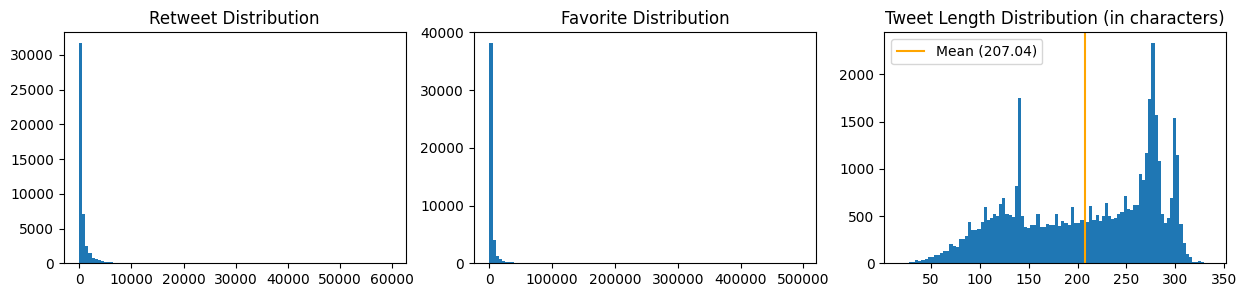

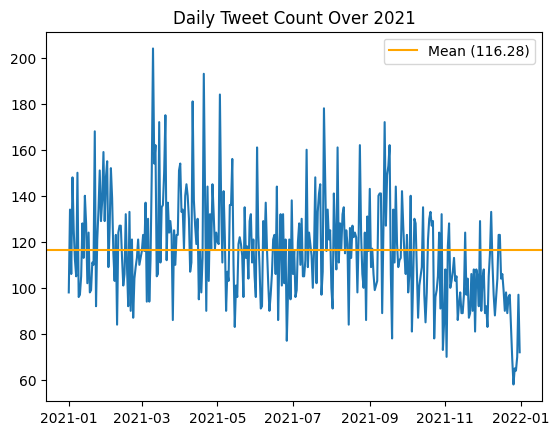

In [308]:
unique_tweets_df = tweets_df.sort_values(['retweet_count','favorite_count']).groupby(['id_str']).tail(1)

print(f"The twitter dataset has {len(tweets_df)} rows but only {len(unique_tweets_df)} unique tweets", end="\n\n")

pd.set_option('max_colwidth', 100)
print('Most popular tweets:')
display(unique_tweets_df[['created_at', 'user', 'text', 'retweet_count', 'favorite_count']].tail(5))

print('Least popular tweets:')
display(unique_tweets_df[['created_at', 'user', 'text', 'retweet_count', 'favorite_count']].head(5))
pd.set_option('max_colwidth', 50)

unique_tweets_df['text_len'] = unique_tweets_df['text'].map(lambda x: len(x) if isinstance(x,str) else None)

retweet_median = unique_tweets_df['retweet_count'].median()
favorite_median = unique_tweets_df['favorite_count'].median()
text_length_mean = unique_tweets_df['text_len'].mean()

fig, ax = plt.subplots(1, 3)

ax[0].hist(unique_tweets_df['retweet_count'], bins=100)
ax[0].set_title('Retweet Distribution')
ax[1].hist(unique_tweets_df['favorite_count'], bins=100)
ax[1].set_title('Favorite Distribution')
ax[2].hist(unique_tweets_df['text_len'], bins=100)
ax[2].set_title('Tweet Length Distribution (in characters)')
ax[2].axvline(text_length_mean, color="orange", label=f"Mean ({text_length_mean:.2f})")
ax[2].legend()
fig.set_figwidth(15)
fig.set_figheight(3)
plt.show()

unique_tweets_df['created_day'] = unique_tweets_df['created_at'].map(lambda x: dt.datetime.fromisoformat(x).date())
unique_tweets_df = unique_tweets_df[(unique_tweets_df['created_day'] >= dt.date(2021, 1, 1)) & (unique_tweets_df['created_day'] < dt.date(2022, 1, 1))]
daily_tweets = unique_tweets_df['created_day'].value_counts()
daily_tweets.sort_index(inplace=True)
daily_tweet_mean = daily_tweets.mean()

plt.plot(daily_tweets)
plt.axhline(daily_tweet_mean, color="orange", label=f"Mean ({daily_tweet_mean:.2f})")
plt.legend()
plt.title('Daily Tweet Count Over 2021')
plt.show()


My initial concern that arises with these summary statistics is that the most popular tweets in the dataset seem to be pro-vaccine while the least popular all seem to be anti-vaccine. This creates a correlative link between the popularity of a tweet and the moral rhetoric used since pro/anti vaccination beliefs were correlated with political identity[$^{9}$](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0250123), and political identity is correlated with moral rhetoric[$^{10}$](https://www.carnegiecouncil.org/media/series/39/20120920-the-righteous-mind-why-good-people-are-divided-by-politics-and-religion). This makes an accurate representation of the twitter "public"'s moral rhetoric difficult since we need to decide between weighting all tweets equally vs weighting them by popularity. If we weight them by popularity then the moral rhetoric that is associated with the pro-vaccine population could overshadow the moral rhetoric of the anti-vaccine population. However, if we choose to treat each tweet equally, we lose valuable information about the exposure and spread of popular tweets throughout the "public" of twitter. In this case, I think it is better to treat tweets equally since retweets & favorites don't necessarily indicate that those interacting with a given tweet reflect its moral rhetoric. 

Interestingly, the least popular tweets include some with 0 likes and 0 retweets which is surprising given the fact that the API calls were made to return "popular" results. However, a cursory look at the profiles that posted these tweets shows that they all have significant followings. This sheds some light onto how "popular" results was interpreted by the API. It's not necessarily returning tweets that have been most interacted with and the reach of the profile that posted it is an important factor.

Lastly, the most popular tweets are from elite figures such as Kamala Harris the United States FDA. This puts our conceptual framework into question where we separate the public and the elites based on platform. It's clear that elite figures are influential on the "public" platform and so the framework may not hold.

## Google News Summary Statistics

The google news dataset has 417051 but only 402352 unique news stories
It contains news stories from 11183 unique domains


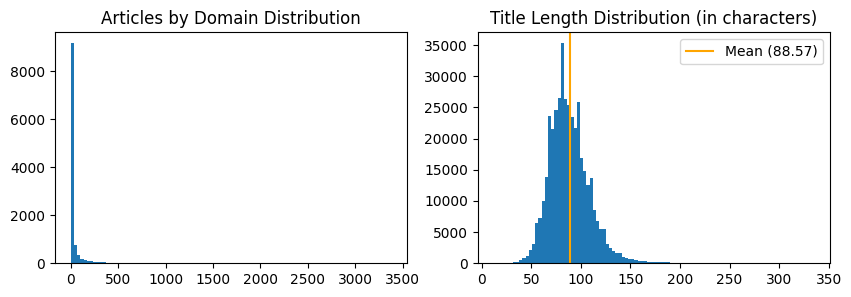

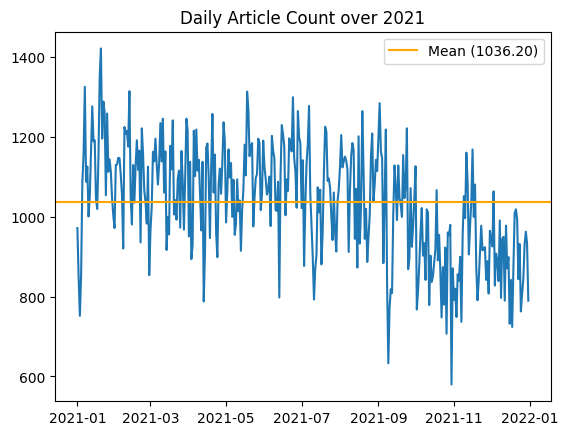

In [309]:
unique_news_df = news_df.groupby('id').head(1)
domains = unique_news_df['link'].map(lambda x: x.split('/')[2])
unique_domains = domains.drop_duplicates()

print(f"The google news dataset has {len(news_df)} but only {len(unique_news_df)} unique news stories")
print(f"It contains news stories from {len(unique_domains)} unique domains")

fig, ax = plt.subplots(1,2)
fig.set_figwidth(10)
fig.set_figheight(3)

domain_counts = domains.value_counts()

ax[0].hist(domain_counts, bins=100)
ax[0].set_title('Articles by Domain Distribution')

unique_news_df['text_len'] = unique_news_df['title'].map(lambda x: len(x) if isinstance(x,str) else None)
title_length_mean = unique_news_df['text_len'].mean()

ax[1].hist(unique_news_df['text_len'], bins=100)
ax[1].set_title('Title Length Distribution (in characters)')
ax[1].axvline(title_length_mean, color="orange", label=f"Mean ({title_length_mean:.2f})")
ax[1].legend()
plt.show()

unique_news_df['created_day'] = unique_news_df['published'].map(lambda x: dateutil.parser.parse(x).date())
unique_news_df = unique_news_df[(unique_news_df['created_day'] >= dt.date(2021, 1, 1)) & (unique_news_df['created_day'] < dt.date(2022, 1, 1))]
daily_news = unique_news_df['created_day'].value_counts()
daily_news.sort_index(inplace=True)
daily_news_mean = daily_news.mean()

plt.plot(daily_news)
plt.axhline(daily_news_mean, color="orange", label=f"Mean ({daily_news_mean:.2f})")
plt.legend()
plt.title('Daily Article Count over 2021')
plt.show()

There's nothing too surprising in the summary statistics for Google News. However, it is good to note that while there is ~9x more data points for Google News then Twitter (402,352 vs. 45,848), the units of analysis, article titles, contain less than half the number of characters than tweets (88 vs 207). With these differences in mind, it will be important to normalize our operationalization of moral rhetoric in order to compare across platforms.

## Operationalizing Moral Rhetoric

I was unable to use the extended Moral Foundations Dictionary package[$^{11}$](https://github.com/medianeuroscience/emfdscore) as it seems it was built on an older version of spaCy[$^{12}$](https://spacy.io/). I was able to update the source code to get it to work but realized it may be complicated to get it working on another's computer. Since the package provides free access to the underlying dictionary that it's built on, I decided to build a custom scorer for compatibility concerns.

The extended Moral Foundations Dictionary looks like this:

| Word    | care_p | fairness_p | loyalty_p | authority_p | sancity_p | care_sent | fairness_sent | loyalty_sent | authority_sent | sanctity_sent
|---------|--------|------------|-----------|-------------|-----------|-----------|---------------|--------------|----------------|--------------
| brought | 0.18   | 0.11       | 0.08      | 0.09        | 0.05      | -0.23     | -0.31         | -0.09        | -0.40          | -0.13
| close   | 0.07   | 0.03       | 0.11      | 0.07        | 0.08      | 0.13      | -0.04         | -0.01        | -0.25          | 0.10
| marine  | 0.02   | 0.01       | 0.04      | 0.0         | 0.0       | -0.39     | -0.02         | -0.13        | 0.0            | 0.0
| ...     | ...    | ...        | ...       | ...         | ...       | ...       | ...           | ...          | ...            | ...

Where all of the variables with "_p" appended are the probability that a given word is associated with that moral foundation. All the variables with "_sent" appended are sentiment scores relative to that moral foundation. My approach will be to take the average moral foundation probability scores of the words in a tweet or article title to get that documents moral foundation probability scores. Then, to get the moral rhetoric profile of twitter or of institutional news sources on a given day, I will take the average of all the tweets or articles on a given day.

In [310]:
moral_df = pd.read_csv('https://raw.githubusercontent.com/medianeuroscience/emfdscore/master/emfdscore/dictionaries/emfd_scoring.csv')

moral_dict = {}
for i, row in moral_df.iterrows():
    moral_dict[row['word']] = {
        'care': row['care_p'],
        'fairness': row['fairness_p'],
        'loyalty': row['loyalty_p'],
        'authority': row['authority_p'],
        'sanctity': row['sanctity_p'],
    }

In [311]:
unique_tweets_df.reset_index(inplace=True, drop=True)
unique_news_df.reset_index(inplace=True, drop=True)
moral_tweets_df = moral_scoring(unique_tweets_df, 'text', moral_dict)
moral_news_df = moral_scoring(unique_news_df, 'title', moral_dict)

In [312]:
scored_tweets_df = pd.concat([unique_tweets_df, moral_tweets_df], axis=1)
scored_news_df = pd.concat([unique_news_df, moral_news_df], axis=1)
pd.set_option('max_colwidth', 100)
print('Scored Tweets')
display(scored_tweets_df[['text', 'created_day', 'care', 'fairness', 'loyalty', 'authority', 'sanctity']].head(5))
print('Scored Article Titles')
display(scored_news_df[['title', 'created_day', 'care', 'fairness', 'loyalty', 'authority', 'sanctity']].head(5))
pd.set_option('max_colwidth', 50)

Scored Tweets


,text,created_day,care,fairness,loyalty,authority,sanctity
0,My prediction on the next phase of COVID lunacy:\n\nGovernments will issue vaccine passports but...,2021-04-03,0.113688,0.140981,0.108238,0.098801,0.111266
1,The so-called 'Covid vaccines' are not vaccines - they are experimental mRNA or genetically modi...,2021-03-31,0.181261,0.135271,0.095175,0.085665,0.119051
2,I have been attacked by many for tweeting about my views on Covid vaccines. The piece below summ...,2021-06-28,0.135425,0.139303,0.117320,0.090414,0.091778
3,From a very good data analyst absolute proof of UK vaccine failure. https://t.co/9gsy2gwMVr,2021-07-16,0.116170,0.150343,0.108119,0.127572,0.100548
4,Let’s be clear we have pathetic weak leaders that have allowed a coup to that place. \n\nWe are ...,2021-07-11,0.134421,0.129646,0.109957,0.131184,0.100440


Scored Article Titles


,title,created_day,care,fairness,loyalty,authority,sanctity
0,University Health to begin offering COVID-19 vaccine to people in Phase 1B at San Antonio mall c...,2021-01-01,0.105794,0.087673,0.065957,0.069671,0.072972
1,New York has administered less than a third of COVID vaccine it has - New York Post,2021-01-01,0.041164,0.060833,0.049915,0.051868,0.032381
2,Nebraska has given 27000 first doses of COVID vaccine - Omaha World-Herald,2021-01-01,0.072993,0.094637,0.065934,0.056537,0.075188
3,CVS: 27000 doses of COVID-19 vaccine have been administered at 176 nursing homes across the stat...,2021-01-01,0.151089,0.086378,0.103062,0.126489,0.087211
4,Navajo Nation president gets COVID-19 vaccine - KOB,2021-01-01,0.065119,0.075707,0.112198,0.097212,0.071896


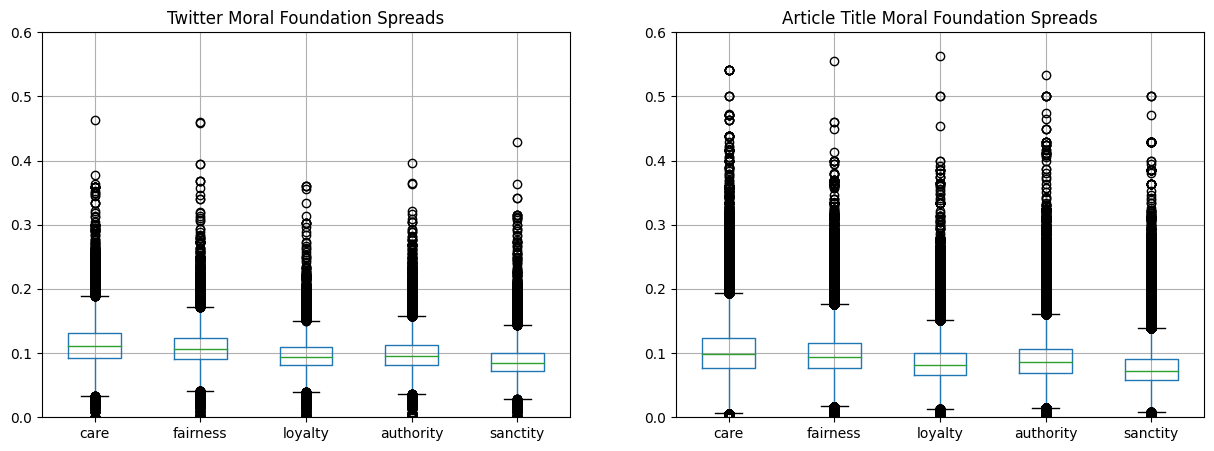

In [313]:
fig, ax = plt.subplots(1,2)
fig.set_figwidth(15)
fig.set_figheight(5)

scored_tweets_df.boxplot(['care', 'fairness', 'loyalty', 'authority', 'sanctity'], ax=ax[0])
ax[0].set_title("Twitter Moral Foundation Spreads")
ax[0].set_ylim([0,.6])
scored_news_df.boxplot(['care', 'fairness', 'loyalty', 'authority', 'sanctity'], ax=ax[1])
ax[1].set_title("Article Title Moral Foundation Spreads")
ax[1].set_ylim([0,.6])
plt.show()

These boxplots show the moral foundations spread for each of our units of analysis, tweets and news article titles. Interestingly, we can see that the average scores for each moral foundation are close between platforms. However, news titles have much higher outliers across all of the 5 foundations. This is partially due to the larger amount of data.

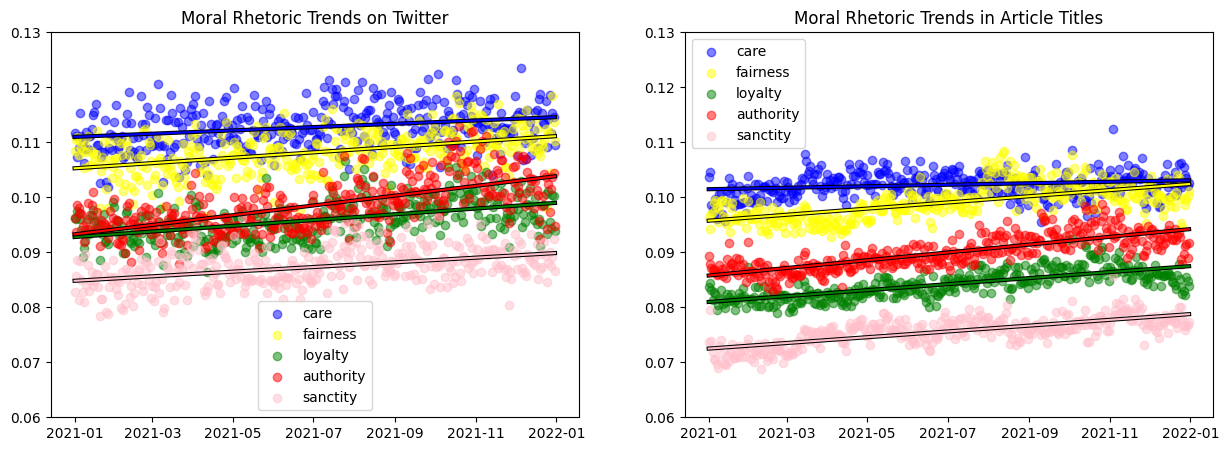

In [314]:
moral_agg = {
    'care': ['min', 'max', 'mean'],
    'fairness': ['min', 'max', 'mean'],
    'loyalty': ['min', 'max', 'mean'],
    'authority': ['min', 'max', 'mean'],
    'sanctity': ['min', 'max', 'mean']
    }

daily_scored_tweets_df = scored_tweets_df.groupby('created_day').agg(moral_agg)

daily_scored_news_df = scored_news_df.groupby('created_day').agg(moral_agg)

fig, ax = plt.subplots(1,2)
fig.set_figwidth(15)
fig.set_figheight(5)

scattered_morals(daily_scored_tweets_df, ax[0])
ax[0].set_title('Moral Rhetoric Trends on Twitter')
ax[0].set_ylim((.06,.13))
scattered_morals(daily_scored_news_df, ax[1])
ax[1].set_title('Moral Rhetoric Trends in Article Titles')
ax[1].set_ylim((.06,.13))
plt.show()

These scatterplots with trendlines seem to show that the use of morally charged rhetoric is steadily increasing over 2021. Interestingly, "authority" on twitter seems to be increasingly particularly quickly while "care" seems to be flat lining relative to the other foundations in news titles. 

# Step 4. Report any bivariate or multivariate comparisons


In [315]:
for foundation in ['care', 'fairness', 'loyalty', 'authority', 'sanctity']:
    daily_scored_tweets_df[(foundation,'normalized')] = daily_scored_tweets_df.apply(lambda x: normalize_morality(x, foundation), axis=1)
    daily_scored_news_df[(foundation,'normalized')] = daily_scored_news_df.apply(lambda x: normalize_morality(x, foundation), axis=1)

In [316]:
combined_df = pd.DataFrame()

combined_df['tweet_care'] = daily_scored_tweets_df[('care', 'normalized')]
combined_df['tweet_fairness'] = daily_scored_tweets_df[('fairness', 'normalized')]
combined_df['tweet_loyalty'] = daily_scored_tweets_df[('loyalty', 'normalized')]
combined_df['tweet_authority'] = daily_scored_tweets_df[('authority', 'normalized')]
combined_df['tweet_sanctity'] = daily_scored_tweets_df[('sanctity', 'normalized')]

combined_df['news_care'] = daily_scored_news_df[('care', 'normalized')]
combined_df['news_fairness'] = daily_scored_news_df[('fairness', 'normalized')]
combined_df['news_loyalty'] = daily_scored_news_df[('loyalty', 'normalized')]
combined_df['news_authority'] = daily_scored_news_df[('authority', 'normalized')]
combined_df['news_sanctity'] = daily_scored_news_df[('sanctity', 'normalized')]
    
combined_df['chi2'] = combined_df.apply(chi_squared_score, axis=1)

day_lag_tweet_df = combined_df[['tweet_care', 'tweet_fairness', 'tweet_loyalty', 'tweet_authority', 'tweet_sanctity']][1:]
day_lag_tweet_df = day_lag_tweet_df.reset_index()
day_lag_news_df = combined_df[['news_care', 'news_fairness', 'news_loyalty', 'news_authority', 'news_sanctity']][0:-1]
day_lag_news_df = day_lag_news_df.reset_index()[['news_care', 'news_fairness', 'news_loyalty', 'news_authority', 'news_sanctity']]

day_lag_df =  pd.concat([day_lag_tweet_df, day_lag_news_df], axis=1)
day_lag_df['chi2'] = day_lag_df.apply(chi_squared_score, axis=1)

week_lag_tweet_df = combined_df[['tweet_care', 'tweet_fairness', 'tweet_loyalty', 'tweet_authority', 'tweet_sanctity']][7:]
week_lag_tweet_df = week_lag_tweet_df.reset_index()
week_lag_news_df = combined_df[['news_care', 'news_fairness', 'news_loyalty', 'news_authority', 'news_sanctity']][0:-7]
week_lag_news_df = week_lag_news_df.reset_index()[['news_care', 'news_fairness', 'news_loyalty', 'news_authority', 'news_sanctity']]

week_lag_df =  pd.concat([week_lag_tweet_df, week_lag_news_df], axis=1)
week_lag_df['chi2'] = week_lag_df.apply(chi_squared_score, axis=1)


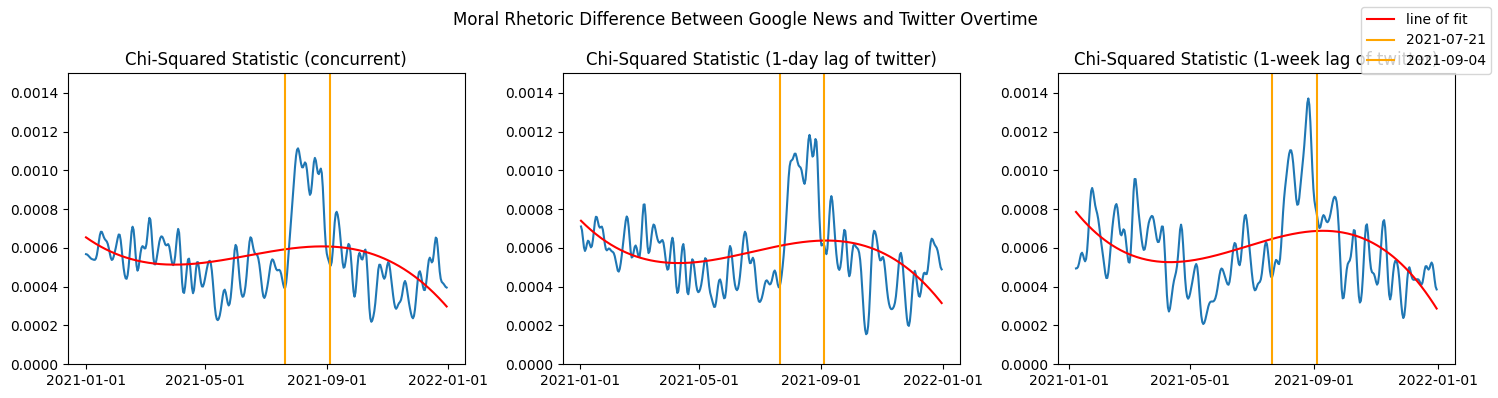

In [317]:
fig, ax = plt.subplots(1,3)
fig.set_figwidth(15)
fig.set_figheight(4)

similarity_subplot(combined_df, 'concurrent', ax[0])
similarity_subplot(day_lag_df, '1-day lag of twitter', ax[1], lagged=True)
similarity_subplot(week_lag_df, '1-week lag of twitter', ax[2], lagged=True)

ax[0].axvline(dt.date(2021,7,21), color='orange', label='2021-07-21')
ax[1].axvline(dt.date(2021,7,21), color='orange')
ax[2].axvline(dt.date(2021,7,21), color='orange')

ax[0].axvline(dt.date(2021,9,4), color='orange', label='2021-09-04')
ax[1].axvline(dt.date(2021,9,4), color='orange')
ax[2].axvline(dt.date(2021,9,4), color='orange')

fig.suptitle('Moral Rhetoric Difference Between Google News and Twitter Overtime')
fig.legend()
fig.tight_layout()
plt.show()

This use of the non-parametric chi-squared test breaks some of the assumptions that would make it statistically valid. In particular, the different moral foundations (e.g. care, fairness, etc.) are not mutually exclusive since a word can have a >0 probability of being associated with multiple foundations. Normally, the chi-squared test is used to test independence between mutually exclusive categorical variables. However, I believe it can be used to visualize difference overtime since it is testing for the independence between platform and the relative probabilities of moral foundations. Nevertheless, no statistical inference can be made from this.

An interesting point to investigate is the spike of the chi-squared statistic between late July and early September. Since the spike appears in the concurrent time series, as well as the lagged series, it's unlikely to be due to a causal relationship between the news and twitter. If it was, the reaction takes place on a shorter time scale than one-day. More likely, is that there was an exogenous event where the news and twitter had divergent moral rhetoric responses.

**However, the similarity between the concurrent and lagged chi-squared statistics time series indicates that there is likely no significant reactionary effect between the moral rhetoric in Google News article titles and popular tweets. If there were, we would see either significantly higher chi-squared statistics (dissimilar) or significantly lower (similar) in the lagged time series. This provides an answer to our initial research question. In this investigation, we have not found any evidence for a reflective or reactionary effect between the google news "elite" and the twitter "public" when it comes to moral rhetoric surrounding the vaccine.**

## Extended Investigation into the Chi-squared August Spike

The chi-squared time series indicated that approximately between the 21st of August and the 4th of September, 2021, there was an unusually high difference between the moral rhetoric in article titles and twitter. Here we will break this down to see what foundations contributed most to this difference by comparing each foundation using t-tests.

There are 44 days that we are comparing in the spike time span


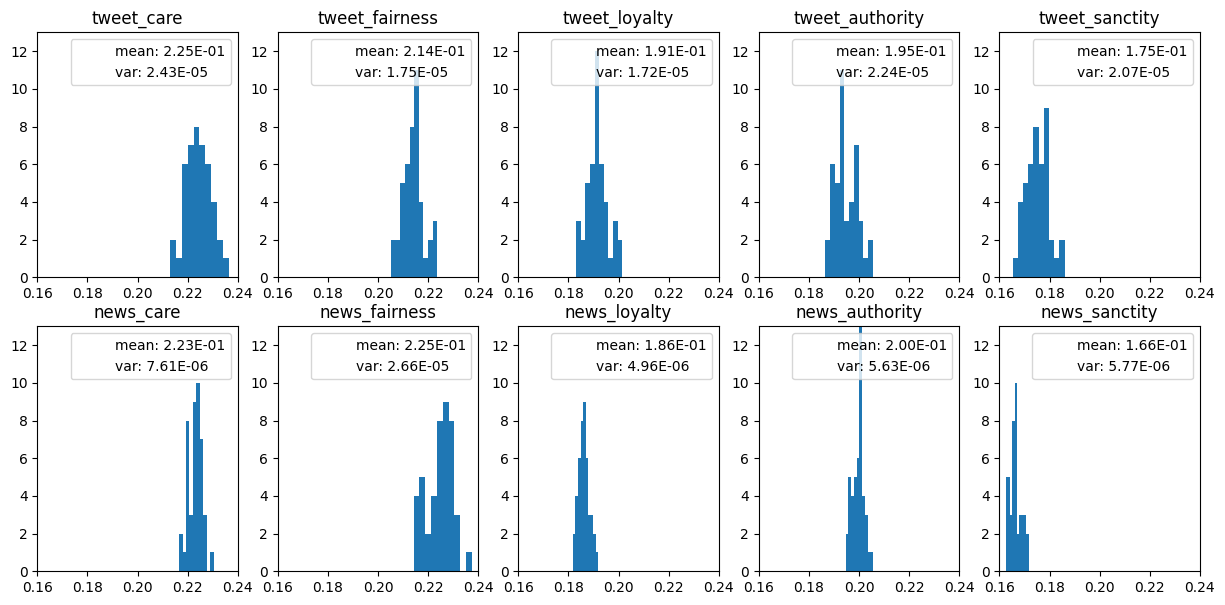

In [318]:
spike_df = combined_df[(combined_df.index > dt.date(2021,7,21)) & (combined_df.index < dt.date(2021,9,4))]

print(f"There are {len(spike_df)} days that we are comparing in the spike time span")

fig, ax = plt.subplots(2,5)
fig.set_figwidth(15)
fig.set_figheight(7)

def moral_hist_subplot(col, axes):
    
    var = spike_df[col].var()
    mean = spike_df[col].mean()

    axes.axvline(mean, alpha=0, label=f"mean: {mean:.2E}")
    axes.axvline(mean, alpha=0, label=f"var: {var:.2E}")

    axes.hist(spike_df[col])
    axes.set_title(col)
    axes.set_xlim(.16, .24)
    axes.set_ylim(0, 13)

    axes.legend()


moral_hist_subplot('tweet_care', ax[0,0])
moral_hist_subplot('tweet_fairness', ax[0,1])
moral_hist_subplot('tweet_loyalty', ax[0,2])
moral_hist_subplot('tweet_authority', ax[0,3])
moral_hist_subplot('tweet_sanctity', ax[0,4])
moral_hist_subplot('news_care', ax[1,0])
moral_hist_subplot('news_fairness', ax[1,1])
moral_hist_subplot('news_loyalty', ax[1,2])
moral_hist_subplot('news_authority', ax[1,3])
moral_hist_subplot('news_sanctity', ax[1,4])

plt.show()

In order to be confident in our use of the t-test, we need to satisfy 3 primary assumptions [$^{13}$](https://www.geeksforgeeks.org/how-to-conduct-a-two-sample-t-test-in-python/)

1. Independence of samples: This is met because we are pulling from two separate platforms and have concluded in the previous section that there is likely no causal relationship between these platforms
2. Samples are Normally Distributed: We can see they generally follow a normal distribution above
3. Sample Variances have less than a 4:1 ratio: For each moral foundation the variance ratios lie within this range

In [319]:
report_ttest(spike_df, 'care')
report_ttest(spike_df, 'fairness')
report_ttest(spike_df, 'loyalty')
report_ttest(spike_df, 'authority')
report_ttest(spike_df, 'sanctity')

The difference in means between the 'care' score for tweets and article titles is 0.0014
There is not a statistically significant (p=0.11) difference in 'care' rhetoric between the tweets and article titles

The difference in means between the 'fairness' score for tweets and article titles is -0.0106
There is a statistically significant (p=0.00) difference in 'fairness' rhetoric between the tweets and article titles

The difference in means between the 'loyalty' score for tweets and article titles is 0.0052
There is a statistically significant (p=0.00) difference in 'loyalty' rhetoric between the tweets and article titles

The difference in means between the 'authority' score for tweets and article titles is -0.0047
There is a statistically significant (p=0.00) difference in 'authority' rhetoric between the tweets and article titles

The difference in means between the 'sanctity' score for tweets and article titles is 0.0087
There is a statistically significant (p=0.00) difference in '

There is a statistically significant difference between the mean scores of the fairness, loyalty, authority, and sanctity foundations. With the tweets using more loyalty and sanctity rhetoric and articles using more fairness and authority rhetoric. 

These findings indicate that whatever exogenous cause led to the increased differential between the moral rhetoric of tweets and news articles caused these platforms to diverge on all foundations except "care". However, the effect size is rather small, all of them except fairness are less than a 1% difference.

# Step 5. Reflect on findings in relation to setup

There are a few interesting findings that we've observed in this investigation that are separate from our initial research question.

1. An increasing use of "authority" rhetoric on twitter relative to other moral foundations
2. A flatlined use of "care" rhetoric in article titles relative to other moral foundations
3. Around July 21st, 2021, an exogeneous event may have led popular tweets to emphasize "loyalty" and "sanctity" while news articles emphasized "fairness" and "authority"

There are a few speculative reflections that could be made based on these findings. First, it's possible that as the vaccine was rolled out and people began to get more comfortable with the idea of getting vaccinated that they were more willing to trust and promote the importance of "authority" in their tweets. Secondly, as more people were vaccinated throughout 2021, there was less of an emphasis on "care" in article titles because the health risks were decreasing and other considerations become relatively important such as healthcare equity, trust in experts, national vs global concerns, etc. Lastly, July 2021 seems to be time period in which the political messaging on the vaccine from politicians as well as news organizations came to a head[$^{14}$](https://en.wikipedia.org/wiki/COVID-19_vaccination_in_the_United_States#July_2021). The increased differences in moral rhetoric may reflect the emergent popularity of this topic rather than a particular exogenous event. 

In regards to our initial research question, *whether the broadcasting of the "elites" is followed with a reflective (similar) or reactionary (dissimilar) moral rhetoric effect in the "public"*, our investigation has proven inconclusive. In retrospect, there are a number of conceptual framing and methodological choices that were problematic.

1. The use of article titles as a representation of "elites" and tweets as a representation of the "public" is problematic since there are many elite figures and news institutions that are present and popular on twitter
2. While ~700,000 tweets were collected most of these were redundant, with only ~45,000 unique tweets. Additionally, it's not clear that these tweets are representative a of twitter as some have very little interaction and are simply posted by individuals with large followings. Additionally, while the tweets were restricted to being in English, they could've been from outside the US which undermines the focus on the United States.
3. Using only article titles rather than their content could be a problematic representation of news institutions' moral rhetoric. Insofar as titles may be used to catch attention while stories are used to give objective information, using titles could misrepresent news institutions. It's also unclear how Google News decides what is popular and so the sample could be biased.
4. The use of moral foundations that aren't mutually exclusive makes analysis complicated because there is likely correlation between each of these foundations that undermine composited interpretations and comparisons. 

In conclusion, this was an interesting investigation that revealed a few potential avenues of future research regarding long-term trends in moral rhetoric and short-term divergences between tweets and article titles. However, the data collection methods and conceptual framing should be more in line with each other and a practically relevant research question.